# Time Series Project

## Business Understanding 

This project is a a regression project on time series data. A store in Ecuador, Favorita wants to be able to make prediction on sales based on all important factors across all its stores. 
This requires preparing existing data into format that enables us to create a good model to make good predictions in the future. It also requires an analysis to get clarity on some features of the data gathered and how they come together to influence outcomes.

## Data Understanding 


### Questions 

1. How are the clusters performing against each other? 
2. What family brings in the most money across all stores?
3. Which locales are the busiest in terms of transactions?
4. In which year did most of the transactions happen?
5. How have sales been over the years?
6. What are the dates of the top 10 sales?
7. What were the dates of the highest sales for each year?
8. How many transactions happen in the christmas period(20th - 31st December) each year?

### Hypothesis 

#### Null: Oil prices do not have an effect on sales 
#### Alternate: Oil prices have an effect on sales

### Data Handling 
### Import necessary libraries

In [1]:

# Data Handling
import pandas as pd 
import numpy as np 

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import mplcursors
import seaborn as sns

# Stationarity 
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss

# Encoding
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Model Selection
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Model Improvement
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Saving Model
import pickle 

# Warnings
import warnings
warnings.filterwarnings('ignore')


### Load Data

In [2]:
train = pd.read_csv("train.csv")
transactions = pd.read_csv("transactions.csv")
holiday = pd.read_csv("holiday.csv")
oil  = pd.read_csv("oil.csv")
stores = pd.read_csv("stores.csv")
test = pd.read_excel('test.xlsx')

### Get an overview of the data frames

In [3]:
# train dataframe
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
# transactions dataframe
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Train Dataframe

- The training data contains information about dates, store numbers, product families, promotions, and sales figures. 
- The data shows sales and time series data for the features store_nbr, family, and onpromotion.
- The store_nbr feature indicates the specific location where the goods are sold by the retailer. 
- The family feature describes the category of goods being sold. 
- The sales column provides the total sales for a particular product family at a specific retailer on a given day. - - - Sales can involve fractional units so decimal values are possible. 
- The onpromotion column indicates the total number of promoted products within a family at a specific store on a specific date.

In [5]:
# holiday dataframe 
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### Holiday Dataframe 

- Shows events and holidays, their descriptions and whether or not it's transferred

In [6]:
# oil dataframe 
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


### Oil Dataframe 
- Oil prices play a crucial role in how things are purchased in Ecuador
- This dataframe shows the oil prices per barrel based on dates

In [7]:
# stores dataframe 
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Stores Dataframe 
- Keeps information on various stores 
- Contains information such as store type, city, cluster and state the store is located 
- Cluster refers to a grouping of related stores 

In [8]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Test Dataframe
- Contains same information as train dataframe
- Contains information that will be used to test the model yet to be trained

## Understand the features/columns of the dataframes

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [10]:
# Change date column to date time 
train['date'] = pd.to_datetime(train['date'])

In [11]:
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [12]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [13]:
# Change date column to date time 
transactions['date'] = pd.to_datetime(transactions['date'])

In [14]:
transactions.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [15]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [16]:
# Change date column to date time 
holiday['date'] = pd.to_datetime(holiday['date'])

In [17]:
holiday.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [18]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [19]:
# Change date column to date time 
oil['date'] = pd.to_datetime(oil['date'])

In [20]:
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [21]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [23]:
# Change date column to date time 
test['date'] = pd.to_datetime(test['date'])

In [24]:
test.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object

### Check for the shape of all dataframes 

In [25]:
train.shape

(3000888, 6)

In [26]:
transactions.shape

(83488, 3)

In [27]:
holiday.shape

(350, 6)

In [28]:
oil.shape

(1218, 2)

In [29]:
stores.shape

(54, 5)

In [30]:
test.shape

(28512, 5)

## Data Preparation

### Check for missing values 

In [31]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [32]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [33]:
holiday.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [34]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [35]:
# look at the numeric values in oil df
oil.describe()

,date,dcoilwtico
count,1218,1175.000000
mean,2015-05-02 12:00:00,67.714366
min,2013-01-01 00:00:00,26.190001
25%,2014-03-03 06:00:00,46.405001
50%,2015-05-02 12:00:00,53.189999
75%,2016-06-30 18:00:00,95.660000
max,2017-08-31 00:00:00,110.620003
std,NaN,25.630476


In [36]:
oil['dcoilwtico']

0             NaN
1       93.139999
2       92.970001
3       93.120003
4       93.199997
          ...    
1213    47.650002
1214    46.400002
1215    46.459999
1216    45.959999
1217    47.259998
Name: dcoilwtico, Length: 1218, dtype: float64

The missing values in the oil dataframe have to be filled. Since the range between minimum and maximum values is very large and the values progress or decrease steadily it will be good to use the forward fill technique

In [37]:
oil['dcoilwtico'].unique()

array([         nan,  93.13999939,  92.97000122,  93.12000275,
        93.19999695,  93.20999908,  93.08000183,  93.80999756,
        93.59999847,  94.26999664,  93.26000214,  94.27999878,
        95.48999786,  95.61000061,  96.08999634,  95.05999756,
        95.34999847,  95.15000153,  95.94999695,  97.62000275,
        97.98000336,  97.65000153,  97.45999908,  96.20999908,
        96.68000031,  96.44000244,  95.83999634,  95.70999908,
        97.01000214,  97.48000336,  97.02999878,  97.30000305,
        96.69000244,  94.91999817,  92.79000092,  92.73999786,
        92.62999725,  92.83999634,  92.02999878,  90.70999908,
        90.12999725,  90.87999725,  90.47000122,  91.52999878,
        92.01000214,  92.06999969,  92.44000244,  92.47000122,
        93.02999878,  93.48999786,  93.70999908,  92.45999908,
        93.41000366,  94.55000305,  95.98999786,  96.52999878,
        97.23999786,  97.09999847,  97.23000336,  95.01999664,
        92.76000214,  93.36000061,  94.18000031,  94.58

In [38]:
# Replace nan value with np.nan
oil.replace('nan', np.nan, inplace=True)

In [39]:
# Fill null values with forward fill
oil = oil.fillna(method = 'ffill')

In [40]:
oil.isna().sum()

date          0
dcoilwtico    1
dtype: int64

In [41]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [42]:
# single missing value is at the start of the dataframe so fill with backward fill 
oil = oil.fillna(method = 'bfill')

In [43]:
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

In [44]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [45]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

### Make Date the index in dataframes

In [46]:
# train dataframe 
train.set_index('date', inplace=True)

In [47]:
train.head(2)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0


In [48]:
# transactions dataframe 
transactions.set_index('date', inplace=True)

In [49]:
transactions.head(2)

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111


In [50]:
# holiday dataframe 
holiday.set_index('date', inplace=True)

In [51]:
holiday.head(2)

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [52]:
# oil dataframe 
oil.set_index('date', inplace=True)

In [53]:
oil.head(2)

,dcoilwtico
date,
2013-01-01,93.139999
2013-01-02,93.139999


In [54]:
# test dataframe 
test.set_index('date', inplace=True)

In [55]:
test.head(2)

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0


### Merge the dataframes

In [56]:
# Merge the train and transactions dataframes based on the date and store number columns
merged = pd.merge(train, transactions, on=['date', 'store_nbr'])

In [57]:
merged.head()

,id,store_nbr,family,sales,onpromotion,transactions
date,,,,,,
2013-01-01,561,25,AUTOMOTIVE,0.0,0,770
2013-01-01,562,25,BABY CARE,0.0,0,770
2013-01-01,563,25,BEAUTY,2.0,0,770
2013-01-01,564,25,BEVERAGES,810.0,0,770
2013-01-01,565,25,BOOKS,0.0,0,770


In [58]:
# Merge the merged dataframe with the holiday dataframe based on the date column
merged = pd.merge(merged, holiday, on='date')

In [59]:
merged.head()

,id,store_nbr,family,sales,onpromotion,transactions,type,locale,locale_name,description,transferred
date,,,,,,,,,,,
2013-01-01,561,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,562,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,563,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,564,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,565,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False


In [60]:
# Merge the merged data with the oil dataframe on the date column
merged = pd.merge(merged, oil, on='date')

In [61]:
merged.head()

,id,store_nbr,family,sales,onpromotion,transactions,type,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,,,
2013-01-01,561,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2013-01-01,562,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2013-01-01,563,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2013-01-01,564,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2013-01-01,565,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


- The date column has been set us the index of the merged dataframe
- This means it will be lost when merged with the stores dataframe on the store_nbr column
- To solve this the index has to be reset

In [62]:
# Reset index
merged.reset_index(inplace=True)

In [63]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   id            322047 non-null  int64         
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   transactions  322047 non-null  int64         
 7   type          322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  dcoilwtico    322047 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 29.8+ MB


In [64]:
# Merge the merged data with the stores dataframe on the stores number column
train = pd.merge(merged, stores, on='store_nbr')

In [65]:
train.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
1,2013-01-01,562,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
2,2013-01-01,563,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
3,2013-01-01,564,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
4,2013-01-01,565,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1


In [66]:
train.tail()

,date,id,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
322042,2017-08-15,3000685,52,POULTRY,397.340,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
322043,2017-08-15,3000686,52,PREPARED FOODS,104.418,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
322044,2017-08-15,3000687,52,PRODUCE,3803.368,8,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
322045,2017-08-15,3000688,52,SCHOOL AND OFFICE SUPPLIES,17.000,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11
322046,2017-08-15,3000689,52,SEAFOOD,7.000,0,2255,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Manta,Manabi,A,11


In [67]:
train.shape

(322047, 17)

### Rename columns to aid understanding
Some column names may not clearly describe the data in them so they need to be renamed

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   id            322047 non-null  int64         
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   transactions  322047 non-null  int64         
 7   type_x        322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  dcoilwtico    322047 non-null  float64       
 13  city          322047 non-null  object        
 14  state         322047 non-null  object        
 15  type_y        322

In [69]:
train.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,2013-01-01,561,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
1,2013-01-01,562,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
2,2013-01-01,563,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
3,2013-01-01,564,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1
4,2013-01-01,565,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Salinas,Santa Elena,D,1


- Change type_x column name to holiday_type to reflect what it is in the Holiday dataframe 
- Change 'dcoilwtico' column name to reflect what it represents ie. oil price 
- Change type_y column name to store_type to reflect what it represents in the stores dataframe 

In [70]:
# Changing column names
train = train.rename(columns= {'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y':'store_type' })

In [71]:
# Confirm the change 
train.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'oil_price', 'city', 'state', 'store_type', 'cluster'],
      dtype='object')

### Preparing data in Merged Dataframe 

In [72]:
# Checking for missing values 
train.isnull().sum()

date            0
id              0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
oil_price       0
city            0
state           0
store_type      0
cluster         0
dtype: int64

In [73]:
# Checking for duplicates 
train.duplicated().sum()

0

In [74]:
# Get summary of numerical values
train.describe()

,date,id,store_nbr,sales,onpromotion,transactions,oil_price,cluster
count,322047,3.220470e+05,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000
mean,2015-08-04 23:49:57.971103488,1.682979e+06,26.994672,406.383452,3.727136,1734.117840,63.686222,8.531202
min,2013-01-01 00:00:00,5.610000e+02,1.000000,0.000000,0.000000,54.000000,27.959999,1.000000
25%,2014-07-23 00:00:00,1.010616e+06,13.000000,1.000000,0.000000,1030.000000,44.880001,4.000000
50%,2015-11-02 00:00:00,1.842406e+06,27.000000,19.000000,0.000000,1409.000000,51.980000,9.000000
75%,2016-05-27 00:00:00,2.209556e+06,40.000000,241.260505,1.000000,2148.000000,94.089996,13.000000
max,2017-08-15 00:00:00,3.000887e+06,54.000000,124717.000000,716.000000,8359.000000,107.949997,17.000000
std,NaN,7.862493e+05,15.595174,1246.881240,15.512095,1050.335018,24.842082,4.713809


### Questions 

#### 1. How are the clusters performing against each other? 

In [75]:
train['cluster'].unique()

array([ 1, 13, 15,  6,  7,  3, 12, 16,  9, 10,  8,  2,  4,  5, 11, 14, 17])

In [76]:
# Show the sales per cluster
cluster_sales = train.groupby('cluster')['sales'].sum().reset_index()
cluster_sales 

,cluster,sales
0,1,6.906517e+06
1,2,3.551141e+06
2,3,9.073348e+06
3,4,5.922079e+06
4,5,7.297347e+06
5,6,1.419835e+07
6,7,1.982032e+06
7,8,1.290252e+07
8,9,3.648523e+06
9,10,1.068829e+07


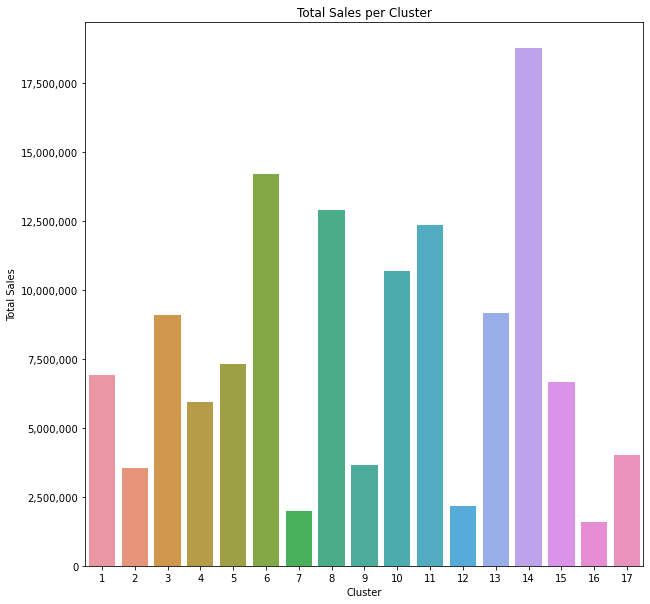

In [77]:
# Plot the sales per Cluster

# Setting figure size
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x='cluster', y='sales', data=cluster_sales, ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales per Cluster')


# Converting y-axis values to full figures
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))


plt.show()

From the plot above we can tell that Cluster 14 is the highest performing cluster and Cluster 16 is the worst performing in terms of sum of sales 

#### 2. What family brings in the most money across all stores?

In [78]:
# Finding the unique families
train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [79]:
# Find the sales per family
family_sales = train.groupby('family')['sales'].sum().reset_index()
family_sales

,family,sales
0,AUTOMOTIVE,6.400100e+04
1,BABY CARE,1.256000e+03
2,BEAUTY,3.979600e+04
3,BEVERAGES,2.606395e+07
4,BOOKS,8.710000e+02
5,BREAD/BAKERY,4.658867e+06
6,CELEBRATION,1.034860e+05
7,CLEANING,1.118853e+07
8,DAIRY,7.496803e+06
9,DELI,2.762202e+06


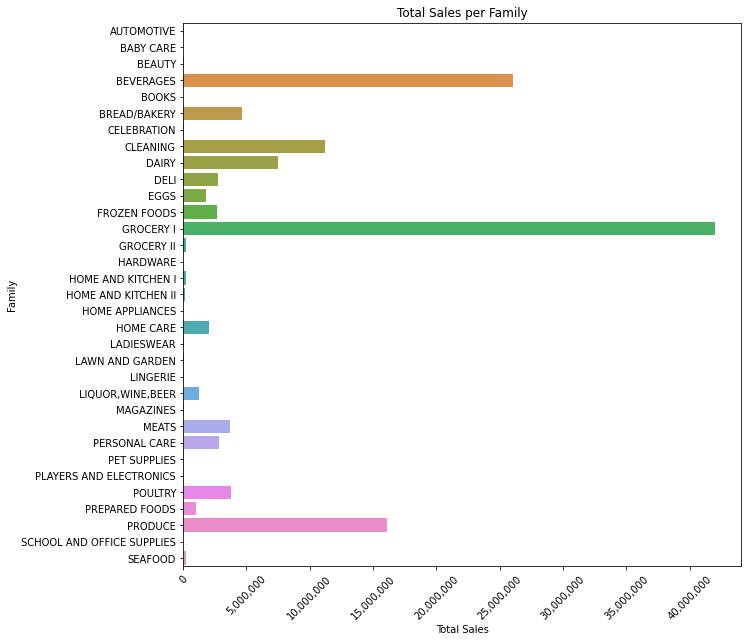

In [80]:
# Plot the sales per family

# Setting figure size
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x='sales', y='family', data=family_sales, ax=ax)
ax.set_xlabel('Total Sales')
ax.set_ylabel('Family')
ax.set_title('Total Sales per Family')
plt.xticks(rotation=45)

# Converting x-axis values to full figures
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))


plt.show()

From the plot above we can tell that GROCERY I is the highest selling 'family' out of the 33 'families'

#### 3. Which locales are the busiest in terms of transactions?

In [81]:
# Find unique locales
train['locale_name'].unique()

array(['Ecuador', 'Cotopaxi', 'Cuenca', 'Imbabura', 'Machala',
       'Latacunga', 'El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil',
       'Esmeraldas', 'Riobamba', 'Quevedo',
       'Santo Domingo de los Tsachilas', 'Santa Elena', 'Ambato', 'Quito',
       'Libertad', 'Puyo', 'Guaranda', 'Loja', 'Salinas', 'Manta',
       'Ibarra'], dtype=object)

In [82]:
# Group transactions by the unique locale_names
locale_trans = train.groupby('locale_name')['transactions'].sum().reset_index()
locale_trans

,locale_name,transactions
0,Ambato,12571053
1,Cayambe,7350420
2,Cotopaxi,11397507
3,Cuenca,10978803
4,Ecuador,295506222
5,El Carmen,11042229
6,Esmeraldas,10915938
7,Guaranda,17751789
8,Guayaquil,20605695
9,Ibarra,4948482


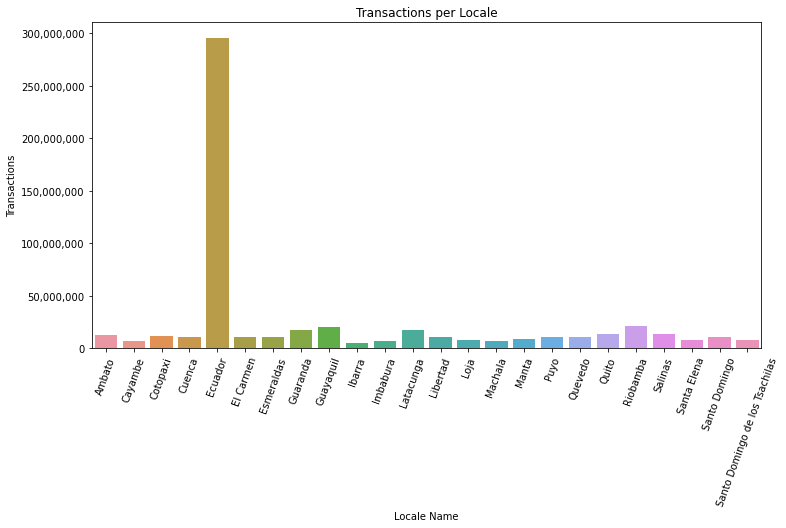

In [83]:
# Plotting the locale names against the number of transactions 
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='locale_name', y='transactions', data=locale_trans, ax=ax)
ax.set_xlabel('Locale Name')
ax.set_ylabel('Transactions')
ax.set_title('Transactions per Locale')

# Rotate x-axis labels
plt.xticks(rotation=70)

# Converting y-axis values to full figures
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.show()

From the above graph we can tell that the locale_name 'Ecuador' had the most transactions

### 4. In which year did most of the transactions happen?

In [84]:
# Create array to store years from date column
train['Year'] = train['date'].dt.year
train['Year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [85]:
# Group transactions by the years
transactions_per_year = train.groupby('Year')['transactions'].count()
transactions_per_year

Year
2013    46266
2014    73524
2015    65901
2016    99198
2017    37158
Name: transactions, dtype: int64

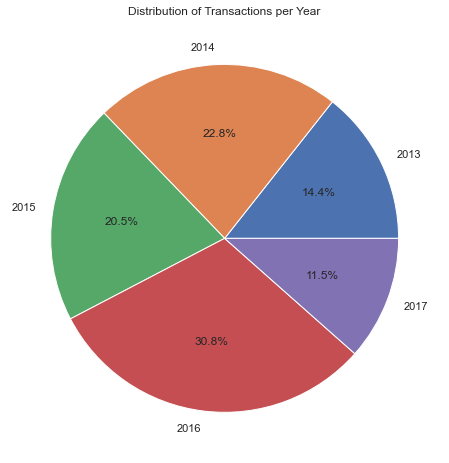

In [86]:
plt.figure(figsize=(8, 8))  # Set the figure size if needed
sns.set(style="whitegrid")

plt.pie(transactions_per_year, labels=transactions_per_year.index, autopct='%1.1f%%')
plt.title('Distribution of Transactions per Year')

plt.show()

From the graph above we can tell that the year 2016 had the most transactions in the dataset

#### 5. How have sales been over the years?

In [87]:
# Create array to store years from date column
train['Year'] = train['date'].dt.year
train['Year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [88]:
# Group sales by the years
sales_per_year = train.groupby('Year')['sales'].sum().reset_index()
sales_per_year

,Year,sales
0,2013,1.166394e+07
1,2014,2.809424e+07
2,2015,2.752824e+07
3,2016,4.566470e+07
4,2017,1.792345e+07


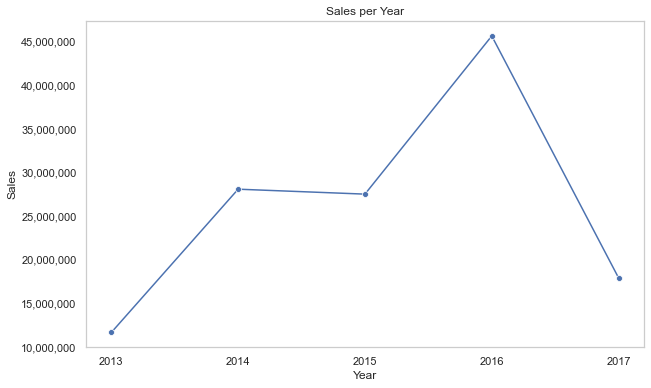

In [89]:
# Plotting Sales per year
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='sales', data=sales_per_year, marker='o')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales per Year')

# Removing grid lines
plt.grid(False)

# Changing x-axis values to integers
plt.xticks(sales_per_year['Year'], sales_per_year['Year'].astype(int))

# Converting y-axis values to full figures
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.show()

#### 6. What are the dates of the top 10 sales?

In [90]:
# Finding the top 10 sales
top_10_sales = train.nlargest(10, 'sales')
top_10_sales

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,Year
80598,2016-05-02,2163723,2,GROCERY I,124717.000,59,1905,Event,National,Ecuador,Terremoto Manabi+16,False,44.750000,Quito,Pichincha,D,13,2016
176607,2016-10-07,2445984,39,MEATS,89576.360,0,1295,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False,49.759998,Cuenca,Azuay,B,6,2016
306066,2016-04-21,2144154,20,GROCERY I,87438.516,53,1692,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,43.180000,Quito,Pichincha,B,6,2016
306067,2016-04-21,2144154,20,GROCERY I,87438.516,53,1692,Event,National,Ecuador,Terremoto Manabi+5,False,43.180000,Quito,Pichincha,B,6,2016
213918,2016-04-18,2139699,45,GROCERY I,76090.000,38,3895,Event,National,Ecuador,Terremoto Manabi+2,False,39.740002,Quito,Pichincha,A,11,2016
80466,2016-04-26,2153031,2,GROCERY I,63434.000,30,1778,Event,National,Ecuador,Terremoto Manabi+10,False,42.520000,Quito,Pichincha,D,13,2016
214029,2016-04-21,2145045,45,GROCERY I,53874.000,44,3079,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,43.180000,Quito,Pichincha,A,11,2016
214030,2016-04-21,2145045,45,GROCERY I,53874.000,44,3079,Event,National,Ecuador,Terremoto Manabi+5,False,43.180000,Quito,Pichincha,A,11,2016
204216,2013-11-12,562596,44,GROCERY I,46271.000,0,3577,Holiday,Local,Ambato,Independencia de Ambato,False,93.120003,Quito,Pichincha,A,5,2013
154518,2014-12-08,1257246,35,GROCERY I,45361.000,3,624,Holiday,Local,Loja,Fundacion de Loja,False,63.130001,Playas,Guayas,C,3,2014


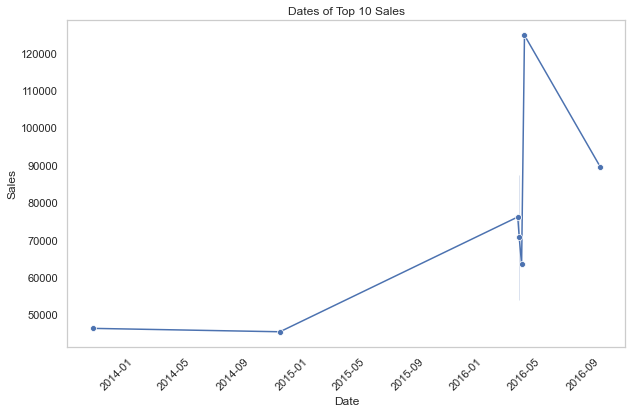

In [91]:
# Plotting the top 10 sales dates
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='sales', data=top_10_sales, marker='o')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Dates of Top 10 Sales')
plt.xticks(rotation=45)

plt.grid(False)
plt.show()

#### 7. What were the dates of the highest sales for each year?

In [92]:
# Finding the highest sales per each year 
highest_sales_per_year = train.groupby(train['date'].dt.year).apply(lambda x: x.loc[x['sales'].idxmax()])
highest_sales_per_year

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,Year
date,,,,,,,,,,,,,,,,,,
2013,2013-11-12,562596,44,GROCERY I,46271.0,0,3577,Holiday,Local,Ambato,Independencia de Ambato,False,93.120003,Quito,Pichincha,A,5,2013
2014,2014-12-08,1257246,35,GROCERY I,45361.0,3,624,Holiday,Local,Loja,Fundacion de Loja,False,63.130001,Playas,Guayas,C,3,2014
2015,2015-11-11,1857219,2,GROCERY I,33274.0,23,1928,Holiday,Local,Latacunga,Independencia de Latacunga,False,42.950001,Quito,Pichincha,D,13,2015
2016,2016-05-02,2163723,2,GROCERY I,124717.0,59,1905,Event,National,Ecuador,Terremoto Manabi+16,False,44.750000,Quito,Pichincha,D,13,2016
2017,2017-01-02,2599488,46,GROCERY I,23966.0,105,5537,Transfer,National,Ecuador,Traslado Primer dia del ano,False,53.750000,Quito,Pichincha,A,14,2017


In [93]:
# Finding the highest dates of the highest sales per each year
highest_sales_date_per_year = highest_sales_per_year[['date', 'sales']].reset_index(drop=True)
highest_sales_date_per_year

,date,sales
0,2013-11-12,46271.0
1,2014-12-08,45361.0
2,2015-11-11,33274.0
3,2016-05-02,124717.0
4,2017-01-02,23966.0


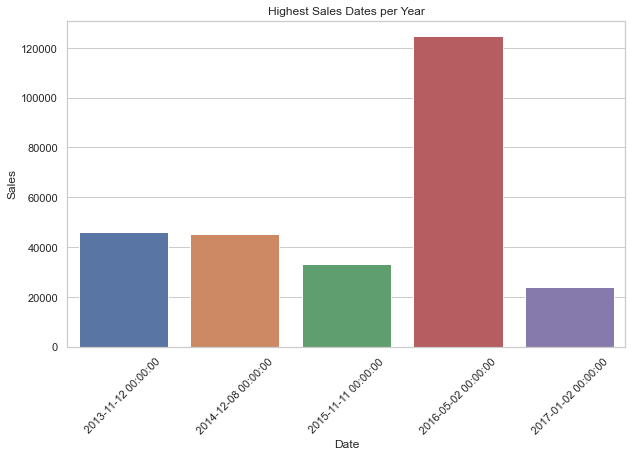

In [94]:
# Plotting the highest sales dates per year

plt.figure(figsize=(10, 6))
sns.barplot(x='date', y='sales', data=highest_sales_date_per_year)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Highest Sales Dates per Year')

plt.xticks(rotation=45)

plt.show()


#### 8. How many transactions happen in the christmas period(20th - 31st December) each year?

In [95]:
# Finding the number of transactions per christmas period
christmas_transactions = train[train['date'].dt.day.between(20, 31) & train['date'].dt.month.eq(12)].groupby(train['date'].dt.year)['transactions'].count()
christmas_transactions

date
2013     6204
2014    11088
2015    10494
2016     8745
Name: transactions, dtype: int64

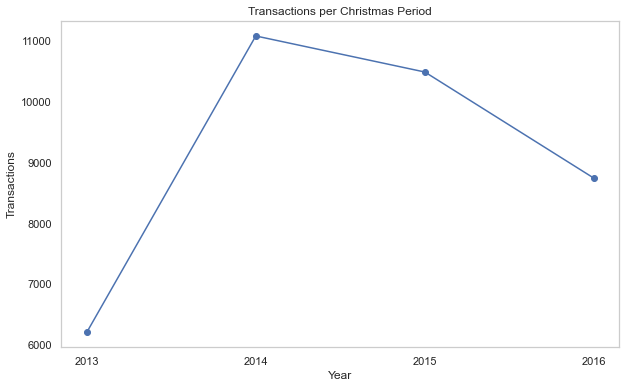

In [96]:
x_values = np.arange(len(christmas_transactions))
plt.figure(figsize=(10, 6))
plt.plot(x_values, christmas_transactions.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Transactions')
plt.title('Transactions per Christmas Period')

# Set x-ticks and labels
plt.xticks(x_values, christmas_transactions.index.astype(int))

# Remove grid lines
plt.grid(False)

plt.show()

### Hypothesis Testing

In [97]:
# Finding the correlation between the sales and oil price
correlation = train['sales'].corr(train['oil_price'])

correlation


-0.061285002039468635

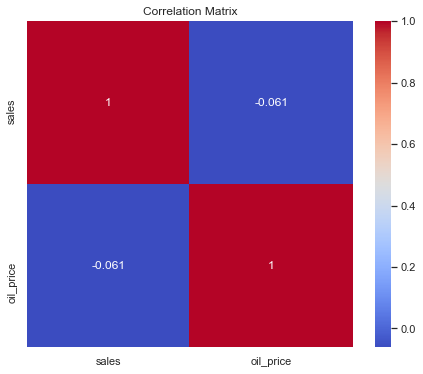

In [98]:
# Plotting a Correlation Matrix
columns_to_analyze = ['sales', 'oil_price']
correlation_matrix = train[columns_to_analyze].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')

plt.show()

There is a weak negative correlation between oil prices and sales which means oil prices do not have a significant effect on sales

#### This means we reject the Alternate Hypothesis that oil prices  have an effect on sales

In [99]:
train.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'oil_price', 'city', 'state', 'store_type', 'cluster',
       'Year'],
      dtype='object')

### Feature Engineering 

#### Drop the unnecessary columns 
Drop id, locale, locale_name, description, transferred, state, store_type columns

In [100]:
train = train.drop(columns = ['id', 'locale','locale_name','description','transferred','state','store_type'], axis=1)

In [101]:
train.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'holiday_type', 'oil_price', 'city', 'cluster', 'Year'],
      dtype='object')

In [102]:
time_data = train 

In [103]:
time_data.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,oil_price,city,cluster,Year
0,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,93.139999,Salinas,1,2013
1,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,93.139999,Salinas,1,2013
2,2013-01-01,25,BEAUTY,2.0,0,770,Holiday,93.139999,Salinas,1,2013
3,2013-01-01,25,BEVERAGES,810.0,0,770,Holiday,93.139999,Salinas,1,2013
4,2013-01-01,25,BOOKS,0.0,0,770,Holiday,93.139999,Salinas,1,2013


In [104]:
time_data['Year']. unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

#### Standardization

In [105]:
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'oil_price']

# fit and transform the numerical columns
time_data[num_cols] = scaler.fit_transform(time_data[num_cols])


#### Feature Encoding

In [106]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   store_nbr     322047 non-null  int64         
 2   family        322047 non-null  object        
 3   sales         322047 non-null  float64       
 4   onpromotion   322047 non-null  int64         
 5   transactions  322047 non-null  float64       
 6   holiday_type  322047 non-null  object        
 7   oil_price     322047 non-null  float64       
 8   city          322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  Year          322047 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(3)
memory usage: 25.8+ MB


In [107]:
# Select the categorical columns
categorical_columns = ["family", "city", "holiday_type"]
categorical_data = time_data[categorical_columns]

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data to one hot encoding
one_hot_encoded_data = encoder.fit_transform(categorical_data)

# Get the categories for each column
categories = [encoder.categories_[i] for i in range(len(encoder.categories_))]

# Create the column names for the one hot encoded data
column_names = []
for i in range(len(categories)):
    for j in range(len(categories[i])):
        column_names.append(f'{categorical_columns[i]}_{categories[i][j]}')

# Convert the one hot encoding data to a DataFrame
one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)


# Reset the index of both dataframes
time_data = time_data.reset_index(drop=True)
one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)

# Concatenate the original dataframe with the one hot encoded data
time_data_encoded = pd.concat([time_data, one_hot_encoded_data], axis=1)

# Drop the original categorical columns
time_data_encoded.drop(categorical_columns, axis=1, inplace=True)

In [108]:
time_data_encoded.head()

,date,store_nbr,sales,onpromotion,transactions,oil_price,cluster,Year,family_AUTOMOTIVE,family_BABY CARE,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,2013-01-01,25,-0.325920,0,-0.917916,1.185642,1,2013,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2013-01-01,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2013-01-01,25,-0.324316,0,-0.917916,1.185642,1,2013,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2013-01-01,25,0.323701,0,-0.917916,1.185642,1,2013,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013-01-01,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [109]:
time_data_encoded = time_data_encoded.drop(columns = 'date', axis=1)

In [110]:
time_data_encoded.head()

,store_nbr,sales,onpromotion,transactions,oil_price,cluster,Year,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25,-0.325920,0,-0.917916,1.185642,1,2013,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,-0.324316,0,-0.917916,1.185642,1,2013,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,25,0.323701,0,-0.917916,1.185642,1,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Split data 

In [111]:
train_set = time_data_encoded.loc[time_data['Year'].isin([2013, 2014, 2015, 2016])]
test_set = time_data_encoded.loc[time_data['Year'].isin([2017])]

In [112]:
train_set.shape

(284889, 67)

In [113]:
test_set.shape

(37158, 67)

In [114]:
train_set

,store_nbr,sales,onpromotion,transactions,oil_price,cluster,Year,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25,-0.325920,0,-0.917916,1.185642,1,2013,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,-0.324316,0,-0.917916,1.185642,1,2013,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,25,0.323701,0,-0.917916,1.185642,1,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25,-0.325920,0,-0.917916,1.185642,1,2013,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320920,22,-0.232429,0,-0.896970,-0.470019,7,2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
320921,22,-0.313088,0,-0.896970,-0.470019,7,2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
320922,22,0.023148,3,-0.896970,-0.470019,7,2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
320923,22,-0.325920,0,-0.896970,-0.470019,7,2016,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [115]:
# Define input features (X) and target variable (y)
X_train = train_set.drop('sales', axis=1)  
y_train = train_set['sales'] 

X_test = test_set.drop('sales', axis=1)  
y_test = test_set['sales']

### Modeling 

####  Model 1 : XGBoost Model

In [116]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)

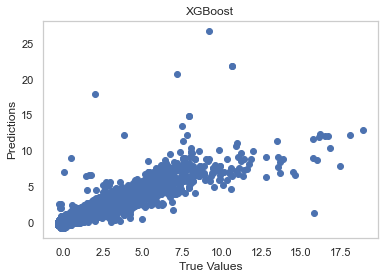

In [117]:
plt.scatter(y_test, xgb_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XGBoost")
plt.grid(False)
plt.show()

####  Evaluation Metrics for XGBoost

In [118]:
xgb_mse = mean_squared_error(y_test, xgb_predictions).round(2)
xgb_rmse = np.sqrt(xgb_mse).round(2)

In [119]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
xgb_predictions_abs = abs(xgb_predictions)

In [120]:
# calculate the mean squared logarithmic error using the new y_test_abs and xgb_predictions_abs array
xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, xgb_predictions_abs)).round(2)

In [121]:
from tabulate import tabulate
# Define the evaluation results in a list
results = [
    ["MSE", xgb_mse],
    ["RMSE", xgb_rmse],
    ["RMSLE", xgb_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for XGBoost:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))


Evaluation Results for XGBoost:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    0.14 │
├──────────┼─────────┤
│ RMSE     │    0.37 │
├──────────┼─────────┤
│ RMSLE    │    0.1  │
╘══════════╧═════════╛


#### Model 2 : Decision Tree Regression Model

In [122]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [123]:
# Make prediction on X_test
dt_predictions = dt.predict(X_test)
dt_predictions

array([-0.32110843, -0.32592044, -0.31950442, ...,  2.9315825 ,
       -0.32511844, -0.26142022])

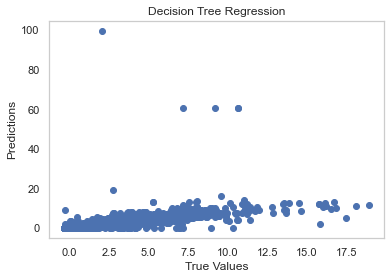

In [124]:
plt.scatter(y_test, dt_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Decision Tree Regression")
plt.grid(False)
plt.show()

####  Evaluation Metrics for Decision Tree Regression

In [125]:
dt_mse = mean_squared_error(y_test, dt_predictions).round(2)


In [126]:
dt_rmse = np.sqrt(dt_mse).round(2)


In [127]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
dt_predictions_abs = abs(dt_predictions)

In [128]:
# calculate the mean squared logarithmic error using the new y_test_abs and dt_predictions_abs array
dt_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, dt_predictions_abs)).round(2)


In [129]:
# Define the evaluation results in a list
results = [
    ["MSE", dt_mse],
    ["RMSE", dt_rmse],
    ["RMSLE", dt_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for Decision Tree Regression:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Evaluation Results for Decision Tree Regression:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    0.69 │
├──────────┼─────────┤
│ RMSE     │    0.83 │
├──────────┼─────────┤
│ RMSLE    │    0.11 │
╘══════════╧═════════╛


#### Model 3 : Linear Regression

In [130]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [131]:
# Make prediction on X_test
lr_predictions = lr.predict(X_test)

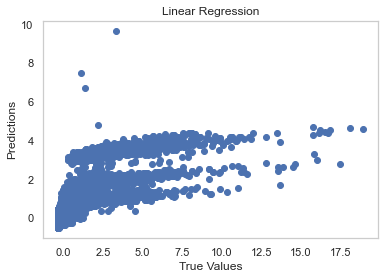

In [132]:
plt.scatter(y_test, lr_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression")
plt.grid(False)
plt.show()

#### Evaluation Metrics for Linear Regression

In [133]:
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)

In [134]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)

In [135]:
# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)

In [136]:
# Define the evaluation results in a list
results = [
    ["MSE", lr_mse],
    ["RMSE", lr_rmse],
    ["RMSLE", lr_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for Linear Regression:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))


Evaluation Results for Linear Regression:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    0.43 │
├──────────┼─────────┤
│ RMSE     │    0.66 │
├──────────┼─────────┤
│ RMSLE    │    0.18 │
╘══════════╧═════════╛


#### Model 4 : Random Forest Regressor

In [137]:
# Random Forest Regression Model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [138]:
# Make prediction on X_test
rf_predictions = rf.predict(X_test)

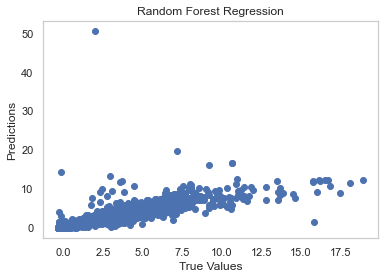

In [139]:
plt.scatter(y_test, rf_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Random Forest Regression")
plt.grid(False)
plt.show()

##### Evaluation Metrics for Random Forest Regression

In [140]:
rf_mse = mean_squared_error(y_test, rf_predictions).round(2)
rf_rmse = np.sqrt(rf_mse).round(2)


In [141]:
# apply the absolute value function to y_test to remove negative signs
#y_test_abs = abs(y_test)
rf_predictions_abs = abs(rf_predictions)

In [142]:
# calculate the mean squared logarithmic error using the new y_test_abs and rf_predictions_abs array
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, rf_predictions_abs)).round(2)

In [143]:
# Define the evaluation results in a list
results = [
    ["MSE", rf_mse],
    ["RMSE", rf_rmse],
    ["RMSLE", rf_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for Random Forest Regressor:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Evaluation Results for Random Forest Regressor:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    0.18 │
├──────────┼─────────┤
│ RMSE     │    0.42 │
├──────────┼─────────┤
│ RMSLE    │    0.08 │
╘══════════╧═════════╛


### Stationarity Test

##### KPSS Test

###### Null Hypothesis : Series is not stationary
###### Alternate Hypothesis : Series is stationary

In [144]:
# Run kpss test 
stats, p, lags, critical_values = kpss(train['sales'], 'ct')


In [145]:
# Displaying test results
print(f'Test statistics: {stats}')
print(f'p-value:{p}')
print(f'critical values: {critical_values}')
if p < 0.05 :
    print("Series is not stationary")
else:
    print("Series is Stattonary")

Test statistics: 4.638434010245462
p-value:0.01
critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not stationary


### Make Data Stationary

In [146]:
# Perform differencing to make the series stationary
train_set['stationary_sales'] = train_set['sales'].diff().fillna(0)

# Run KPSS test on the differenced series
stats, p, lags, critical_values = kpss(train_set['stationary_sales'], 'ct')

# Display test results
print(f'Test statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')
if p < 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


Test statistics: 0.001674191286430398
p-value: 0.1
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is stationary


It is important to make the data stationary before training the Stats Models

#### Model 5 : Auto Regressive Model

In [147]:
# Create an instance of the AR model
ar = AutoReg(y_train, lags=1)
# Fit the model to the training data
ar_fit = ar.fit()

In [148]:
ar_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:               284889
Model:                     AutoReg(1)   Log Likelihood             -399544.142
Method:               Conditional MLE   S.D. of innovations              0.984
Date:                Mon, 31 Jul 2023   AIC                         799094.283
Time:                        10:37:49   BIC                         799125.963
Sample:                             1   HQIC                        799103.466
                               284889                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.002     -3.918      0.000      -0.011      -0.004
sales.L1       0.0913      0.002     48.916      0.000       0.088       0.095
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.9572           +0.0000j           10.9572            0.0000
-----------------------------------------------------------------------------
"""

In [149]:
# Make predictions on the test data
ar_predictions = ar_fit.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1)

#### Evaluation for AR model 

In [150]:
ar_mse = mean_squared_error(y_test, ar_predictions).round(2)
ar_rmse = np.sqrt(ar_mse).round(2)

In [151]:
# apply the absolute value function to y_test to remove negative signs
#y_test_abs = abs(y_test)
ar_predictions_abs = abs(ar_predictions)

In [152]:
# calculate the mean squared logarithmic error using the new y_test_abs and ar_predictions_abs array
ar_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, ar_predictions_abs)).round(2)

In [153]:
# Define the evaluation results in a list
results = [
    ["MSE", ar_mse],
    ["RMSE", ar_rmse],
    ["RMSLE", ar_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for Auto Regressive Model:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Evaluation Results for Auto Regressive Model:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    1.19 │
├──────────┼─────────┤
│ RMSE     │    1.09 │
├──────────┼─────────┤
│ RMSLE    │    0.45 │
╘══════════╧═════════╛


#### Model 6 : ARIMA Model

In [154]:
p = 1
d = 0 
q = 0 # --> p and q are equal to zero as data is already stationary

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p,d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

In [155]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:               284889
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -399545.100
Date:                Mon, 31 Jul 2023   AIC                         799096.200
Time:                        10:38:03   BIC                         799127.880
Sample:                             0   HQIC                        799105.383
                             - 284889                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0079      0.002     -3.355      0.001      -0.013      -0.003
ar.L1          0.0913      0.000    455.254      0.000       0.091       0.092
sigma2         0.9676      0.000   6199.755      0.000       0.967       0.968
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):        7081896948.91
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                            14.31
Prob(H) (two-sided):                  0.00   Kurtosis:                       774.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
# Make predictions on the test data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1)

#### Evaluation for ARIMA model 

In [157]:
arima_mse = mean_squared_error(y_test, arima_predictions).round(2)
arima_rmse = np.sqrt(arima_mse).round(2)

In [158]:
# apply the absolute value function to y_test to remove negative signs
#y_test_abs = abs(y_test)
arima_predictions_abs = abs(arima_predictions)

In [159]:
# calculate the mean squared logarithmic error using the new y_test_abs and arima_predictions_abs array
arima_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, arima_predictions_abs)).round(2)

In [160]:
# Define the evaluation results in a list
results = [
    ["MSE", arima_mse],
    ["RMSE", arima_rmse],
    ["RMSLE", arima_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for ARIMA Model:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Evaluation Results for ARIMA Model:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    1.19 │
├──────────┼─────────┤
│ RMSE     │    1.09 │
├──────────┼─────────┤
│ RMSLE    │    0.45 │
╘══════════╧═════════╛


#### Model 7: SARIMAX

In [161]:
# Set the seasonal order parameters
P = 0  # Seasonal autoregressive order
D = 0  # Seasonal differencing order
Q = 0  # Seasonal moving average order
m = 0  # Number of time steps in each season

# Create an instance of the SARIMAX model
sarimax = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, m))

# Fit the model to the training data
sarimax_fit = sarimax.fit()

In [162]:
# Make predictions on the test data
sarimax_predictions = sarimax_fit.get_prediction(start=len(y_train), end=len(y_train) + len(X_test) - 1)

# Extract the predicted values
sarimax_predictions_values = sarimax_predictions.predicted_mean
sarimax_predictions_values


284889   -0.029691
284890   -0.002711
284891   -0.000248
284892   -0.000023
284893   -0.000002
            ...   
322042    0.000000
322043    0.000000
322044    0.000000
322045    0.000000
322046    0.000000
Name: predicted_mean, Length: 37158, dtype: float64

#### Evaluation for SARIMAX model 

In [163]:
sarimax_mse = mean_squared_error(y_test, sarimax_predictions_values).round(2)
sarimax_rmse = np.sqrt(sarimax_mse).round(2)

In [164]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
sarimax_predictions_abs = np.abs(sarimax_predictions_values)

In [165]:
# calculate the mean squared logarithmic error using the new y_test_abs and sarimax_predictions_abs array
sarimax_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, sarimax_predictions_abs)).round(2)

In [166]:
# Define the evaluation results in a list
results = [
    ["MSE", sarimax_mse],
    ["RMSE", sarimax_rmse],
    ["RMSLE", sarimax_rmsle]
]

# Print the evaluation results in a table
print("\nEvaluation Results for SARIMAX Model:")
print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))



Evaluation Results for SARIMAX Model:
╒══════════╤═════════╕
│ Metric   │   Value │
╞══════════╪═════════╡
│ MSE      │    1.19 │
├──────────┼─────────┤
│ RMSE     │    1.09 │
├──────────┼─────────┤
│ RMSLE    │    0.46 │
╘══════════╧═════════╛


### Model Selection

In [167]:
RMSLES = [
    ["XG Boost", xgb_rmsle],
    ["Linear Regression", lr_rmsle],
    ["Decision Tree Regressor", dt_rmsle],
    ["Random Forest Regressor", rf_rmsle],
    ["AR Model", ar_rmsle],
    ["ARIMA Model", arima_rmsle],
    ["SARIMAX Model", sarimax_rmsle]
]

# Print the evaluation results in a table
print("\n RMSLE of all the Models:")
print(tabulate(RMSLES, headers=["Model", "RMSLE"], tablefmt="fancy_grid"))



 RMSLE of all the Models:
╒═════════════════════════╤═════════╕
│ Model                   │   RMSLE │
╞═════════════════════════╪═════════╡
│ XG Boost                │    0.1  │
├─────────────────────────┼─────────┤
│ Linear Regression       │    0.18 │
├─────────────────────────┼─────────┤
│ Decision Tree Regressor │    0.11 │
├─────────────────────────┼─────────┤
│ Random Forest Regressor │    0.08 │
├─────────────────────────┼─────────┤
│ AR Model                │    0.45 │
├─────────────────────────┼─────────┤
│ ARIMA Model             │    0.45 │
├─────────────────────────┼─────────┤
│ SARIMAX Model           │    0.46 │
╘═════════════════════════╧═════════╛


The best performing model amongst the models trained is the Linear Regression Model so it is selected for improvement 

### Model Improvement

In [168]:
# Perform one-hot encoding on categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

 

# Align the dataframes to ensure they have the same columns after encoding
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

 

# Create the Random Forest Regressor model with the initial/default hyperparameters
rf_model = RandomForestRegressor(random_state=42)

 

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

 

# Make predictions on the test set using the trained Random Forest model
y_pred = rf_model.predict(X_test)

 

 

#y_test_abs = abs(y_test)
rf_predictions_abs = abs(rf_predictions)

# Calculate RMSLE for backtesting evaluation (using absolute values)
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_test), np.abs(y_pred)))
print("RMSLE on Test Set:", rmsle)

 

#mse = mean_squared_error(y_test, y_pred)
#print("MSE on Test Set:", mse)

RMSLE on Test Set: 0.0846211712764056


### Predicting Sales in Test Dataset

In [169]:
test.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [170]:
# Merging test with stores dataset
test = pd.merge(test, transactions, on=['date', 'store_nbr'])

In [171]:
test.head()

,id,store_nbr,family,onpromotion,transactions
date,,,,,


### Save the Model, Scaler & Encoder 


In [172]:
# Save the model to a file
with open('sales_model.pkl', 'wb') as sales_forecaster:
    pickle.dump(rf_model, sales_forecaster)

In [173]:
# Saving Scaler 
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Saving Encoder 
with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)